In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [ ]:
#I guess do this for now?
#tf.config.run_functions_eagerly(False)

# Load in images

In [2]:
#load/preprocess.

POINTS1=np.float32([[220,40],[895,65],[310,810],[930,780]])
SIZE = 512
POINTS2 = np.float32([[0,0],[SIZE,0],[0,SIZE],[SIZE,SIZE]])

M = cv.getPerspectiveTransform(POINTS1,POINTS2)
#gray_mask = cv.warpPerspective(pre_gray_mask,M,(700,700))

def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        print("Band%d.jpg" % i)
        if img is not None:
            #convert to black and white
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            #warp so the mask is square
            img = cv.warpPerspective(img,M,(SIZE,SIZE))
            images.append(img)
        
        #do same for mask
        marsh_mask = cv.imread("marsh_mask.jpg")
        marsh_mask = cv.cvtColor(marsh_mask, cv.COLOR_BGR2GRAY)
        marsh_mask = cv.warpPerspective(marsh_mask,M,(SIZE,SIZE))
        
    images = np.array(images)

    return images,marsh_mask
    
    #for filename in os.listdir(folder):
    #    img = cv.imread(os.path.join(folder,filename))
    #    if img is not None:
    #        images.append(img)
    #return images




In [3]:
#process marsh images 

marsh_images_gray,gray_mask = load_marsh_images("train_jpg")
#try converting to greyscale 


Band1.jpg
Band2.jpg
Band3.jpg
Band4.jpg
Band5.jpg
Band6.jpg
Band7.jpg
Band8.jpg
Band9.jpg
Band10.jpg
Band11.jpg


In [4]:
marsh_images_gray.shape

(11, 512, 512)

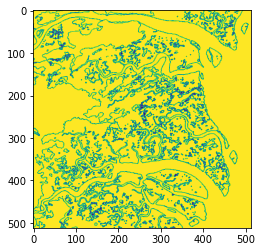

In [5]:
#convert to grayscale 
#gray_marsh = cv.cvtColor(marsh_images[7], cv.COLOR_BGR2GRAY)
#plt.imshow(gray_marsh)
plt.imshow(gray_mask)


# Preliminary attempt 

Use many crops of the images/labels as training data for u-nets. Train to guess boundary or not boundary (at first). 

Issues to be solved: 

1. The solutions need to be stiched together somehow. 
2. The solution does not automatically output a curve - the boundary can be wider than 1.
3. The solution does not know what is marsh, water, etc. A solution to this might be to instead output three classes, then compare the boundary.
4. The mask only covers part of the image and has a weird shape. Also the parallelogram is included, which it shouldn't be. I think the right thing to do is to somehow mask off what's outside the parallelogram. 
5. Can't use any pre-trained u-net out of the box because of the extra image bands - need one with enough channels.

## Extracting patches

In [41]:




def get_patches(img_list,patch_size,patch_stride,mask=False):
    
    image = tf.convert_to_tensor(img_list, dtype =tf.float32)/255.0
    
    
    if mask:
        HEIGHT,WIDTH = image.shape
        reshaped_image = tf.reshape(image,[1,HEIGHT,WIDTH,1])
    else:
        BANDS,HEIGHT,WIDTH = image.shape
        reshaped_image = tf.transpose(image, perm=[1,2,0])
        reshaped_image = tf.reshape(reshaped_image,[1,HEIGHT,WIDTH,BANDS])



    patches = tf.image.extract_patches(images=reshaped_image,
                               sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
                               strides=[1, PATCH_STRIDE, PATCH_STRIDE, 1],
                               rates=[1, 1, 1, 1],
                               padding='VALID')

    if mask:
        patches = tf.reshape(patches,[-1,PATCH_SIZE,PATCH_SIZE,1])
    else:
        patches = tf.reshape(patches,[-1,PATCH_SIZE,PATCH_SIZE,BANDS])
    
    
    return patches 



    

In [43]:
PATCH_SIZE = 128
PATCH_STRIDE = 10

TEST_SIZE = 300

patches = get_patches(marsh_images_gray[:,:TEST_SIZE,:],PATCH_SIZE,PATCH_STRIDE)
mask_patches = get_patches(gray_mask[:TEST_SIZE,:],PATCH_SIZE,PATCH_STRIDE,mask=True)

test_patches = get_patches(marsh_images_gray[:,TEST_SIZE:,:],PATCH_SIZE,PATCH_STRIDE)
test_mask = get_patches(gray_mask[TEST_SIZE:,:],PATCH_SIZE,PATCH_STRIDE,mask=True)



(351, 128, 128, 11) (351, 128, 128, 1)
(702, 128, 128, 11) (702, 128, 128, 1)


<Figure size 432x288 with 0 Axes>

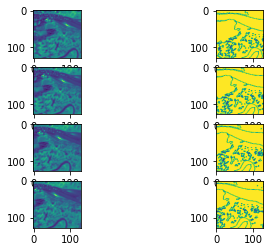

In [44]:
#make sure they line up
plt.figure()

f, axarr = plt.subplots(4,2) 

for i in range(4):
    axarr[i][0].imshow(patches.numpy()[20 + i,:,:,7])
    axarr[i][1].imshow(mask_patches.numpy()[20 + i,:,:,0])
print(test_patches.shape,test_mask.shape)
print(patches.shape,mask_patches.shape)

## Training from patches 

In [10]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output



In [46]:
mask_patches.shape

TensorShape([702, 128, 128, 1])

In [47]:
#do a 50-50 split for now - top half of image
#TRAIN_RATIO = 2
#TRAIN_LENGTH = num_patches//TRAIN_RATIO
BATCH_SIZE = 64
BUFFER_SIZE = 100
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [48]:
#define train_images 

#I need to convert to a tensorflow dataset, I guess. 

#so right now I just have a big tensor. Need to say X_train = one part, y_train = another part.

#patches.shape

patch_dataset = tf.data.Dataset.from_tensor_slices((patches,mask_patches))

#patch_dataset

test_dataset = tf.data.Dataset.from_tensor_slices((test_patches,test_mask))

In [49]:
#batches

#try it without shuffling - this may be causing leakage

train_batches = (
    patch_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    #.repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)

# Setting up dataset without patching

In [6]:
# do the above preprocessing steps without the patching. 

def get_tensors(img_list,mask=False):
    
    image = tf.convert_to_tensor(img_list, dtype =tf.float32)/255.0
    
    
    if mask:
        HEIGHT,WIDTH = image.shape
        reshaped_image = tf.reshape(image,[1,HEIGHT,WIDTH,1])
    else:
        BANDS,HEIGHT,WIDTH = image.shape
        reshaped_image = tf.transpose(image, perm=[1,2,0])
        reshaped_image = tf.reshape(reshaped_image,[1,HEIGHT,WIDTH,BANDS])
        
    return reshaped_image





In [7]:

TEST_SIZE = 256

patches = get_tensors(marsh_images_gray[:,:TEST_SIZE,:])
mask_patches = get_tensors(gray_mask[:TEST_SIZE,:],mask=True)

test_patches = get_tensors(marsh_images_gray[:,TEST_SIZE:,:])
test_mask = get_tensors(gray_mask[TEST_SIZE:,:],mask=True)


patch_dataset = tf.data.Dataset.from_tensor_slices((patches,mask_patches))

#patch_dataset

test_dataset = tf.data.Dataset.from_tensor_slices((test_patches,test_mask))

train_batches = (
    patch_dataset
    .cache()
    #.shuffle(BUFFER_SIZE)
    .batch(1)
    #.repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(1)

Metal device set to: Apple M1


2022-02-21 21:46:35.579933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-21 21:46:35.580272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Creating the model
I used the same neural network from the tutorial but with a 1x1 convolution to change the number of channels.

In [8]:
#tried to use mobilenet with more channels, got issues.

base_model = tf.keras.applications.MobileNetV2(input_shape=[None, None, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [11]:
# try to implement mobilenet (or something like it) myself. 
# for now just try to guess if mask/not mask?
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [12]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])

    #try to do a 1x1 convolution to get it down to size.
    #reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
    reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
  # Downsampling through the model
    #skips = down_stack(inputs)
    skips = down_stack(reduce_channel)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 36          input_6[0][0]                    
__________________________________________________________________________________________________
model_4 (Functional)            [(None, None, None,  1841984     conv2d_2[0][0]                   
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, None, None, 5 1476608     model_4[0][4]                    
____________________________________________________________________________________________

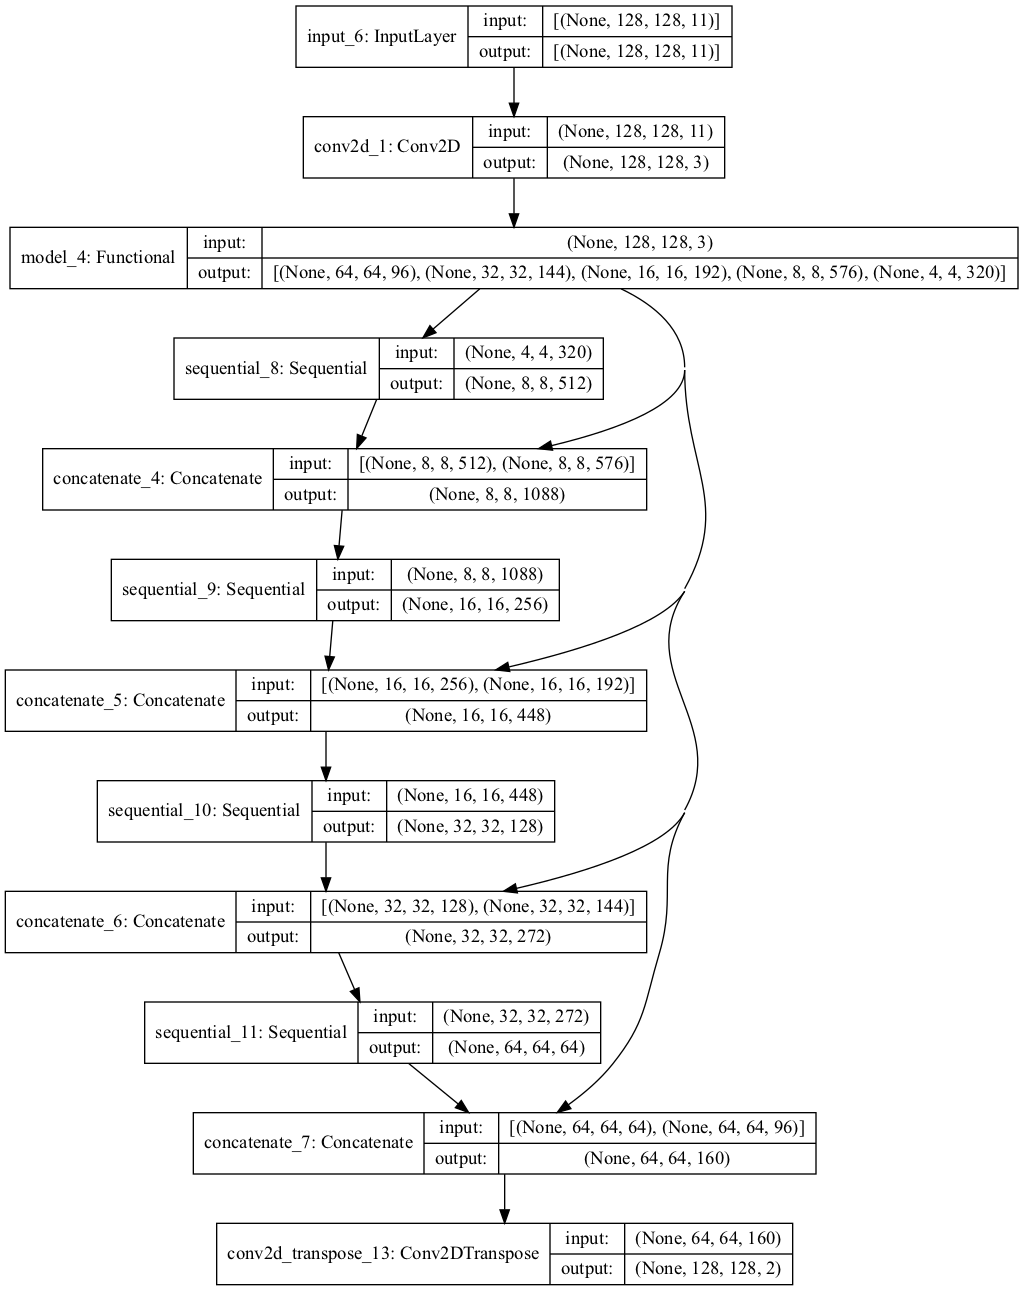

In [70]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Testing the model

Try out the model to check what it predicts before training.

In [16]:
#for images, masks in train_batches.take(2):
#  sample_image, sample_mask = images[0], masks[0]
#  display([sample_image, sample_mask])

for patch,mask in test_dataset.take(1):
    sample_image,sample_mask = patch, mask
#for mask in mask_dataset.take(40):
#    sample_mask = mask



In [15]:
#to show the 
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
def show_predictions_loaded(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = loaded_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(loaded_model.predict(sample_image[tf.newaxis, ...]))])
    
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i][:,:,:3]))
    plt.axis('off')
  plt.show()

2022-02-21 21:47:46.923513: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-21 21:47:47.164084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


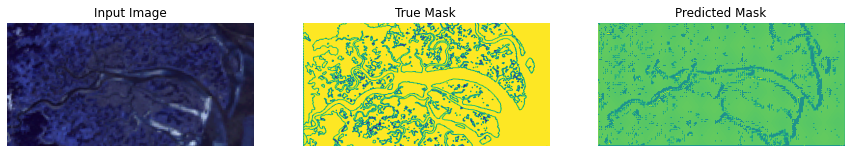

In [17]:
#im = patch[:,:,:3]
#im.shape
show_predictions()

#wow, it actually does something!!! 

# Training the model

Going to give it a shot. 

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    #print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

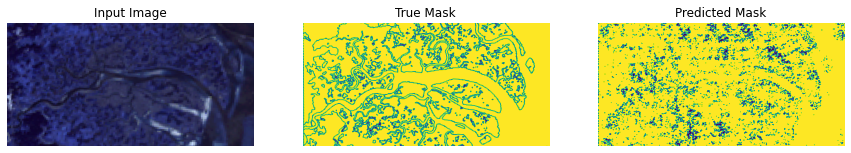

In [22]:
EPOCHS = 1000
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS



model_history = model.fit(train_batches, epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()]
                         )

# Save the model



In [24]:
model.save('saved-model-unpatched')

INFO:tensorflow:Assets written to: saved-model-unpatched/assets


/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [31]:
#loading model?
loaded_model = tf.keras.models.load_model('saved-model-unweighted')

2022-02-14 14:40:14.819580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


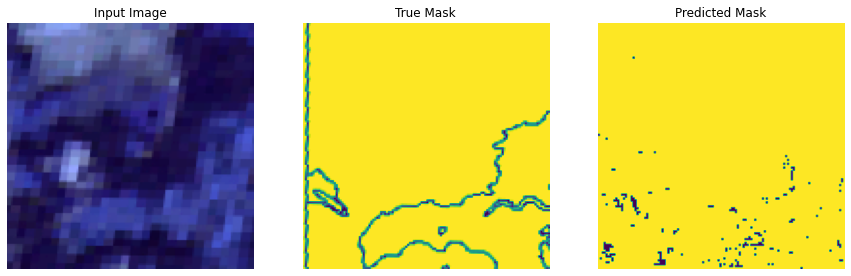

In [32]:
show_predictions_loaded()

# Weighted model

Currently broken.

2022-02-20 17:41:13.571500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


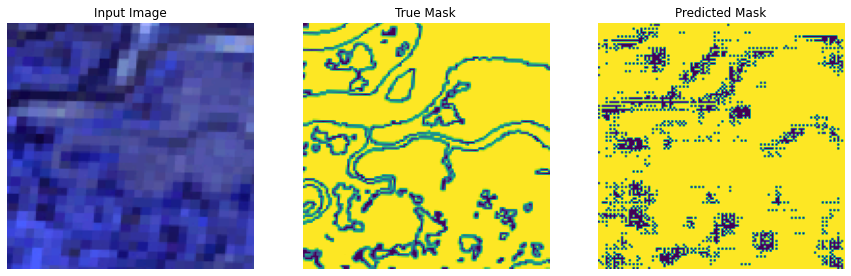

In [27]:
#first inspect
for patch,mask in test_dataset.skip(20).take(1):
    sample_image,sample_mask = patch, mask
    show_predictions_weighted()

In [21]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [78]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [23]:
OUTPUT_CLASSES = 2
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [24]:
def show_predictions_weighted(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = weighted_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(weighted_model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback_weighted(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #if epoch % 3 == 0:
    clear_output(wait=True)
    show_predictions_weighted()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


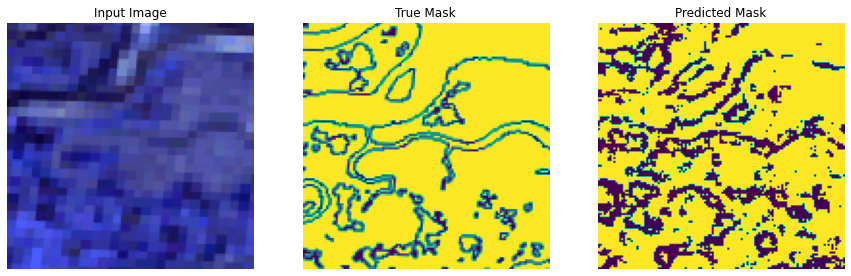


Sample Prediction after epoch 500

Epoch 501/1000
13/35 [==========>...................] - ETA: 13s - loss: 0.0547 - accuracy: 0.7997

In [ ]:
EPOCHS = 1000
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS



weighted_model_history = weighted_model.fit(train_batches.map(add_sample_weights), epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback_weighted()]
                         )

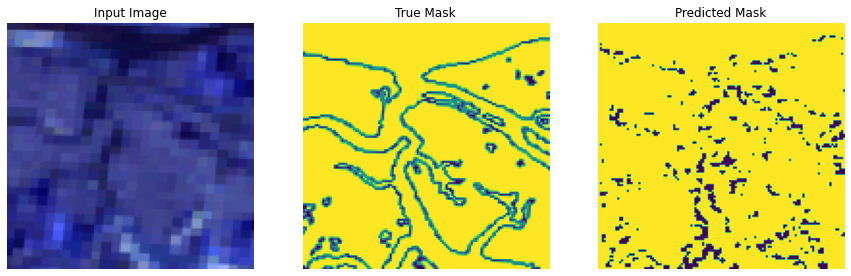

In [184]:
for patch,mask in test_dataset.skip(10).take(1):
    sample_image,sample_mask = patch, mask
    show_predictions_weighted()

In [59]:
# big question - is there data leakage?
model.save('saved-model-transformed')

2022-02-12 00:09:49.960048: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-model-transformed/assets


/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Trying to use inputs of different size

Got it! Just input none for image dimensions when creating model, will resize automatically and use same weights (it appears). 

Could upsampling be creating wierd artifacts? Will this work for non-square image, meaning we could train it on half and test on half? Can we try only having it predict certain parts of the image rather than only showing it those parts?

In [27]:
marsh_tensor = tf.convert_to_tensor(marsh_images_gray, dtype =tf.float32)/255.0
marsh_tensor.shape
marsh_tensor = tf.transpose(marsh_tensor, perm=[1,2,0])
marsh_tensor = tf.reshape(marsh_tensor,[1,SIZE,SIZE,11])
marsh_tensor.shape

TensorShape([1, 512, 512, 11])

In [28]:
pred = model.predict(marsh_tensor)

2022-02-22 10:30:38.136276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [87]:
#display([create_mask(pred)])
#display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [29]:
mask_tensor = tf.convert_to_tensor(gray_mask, dtype=tf.float32)/255.0

In [30]:
mask_tensor = tf.reshape(mask_tensor,[512,512,1])

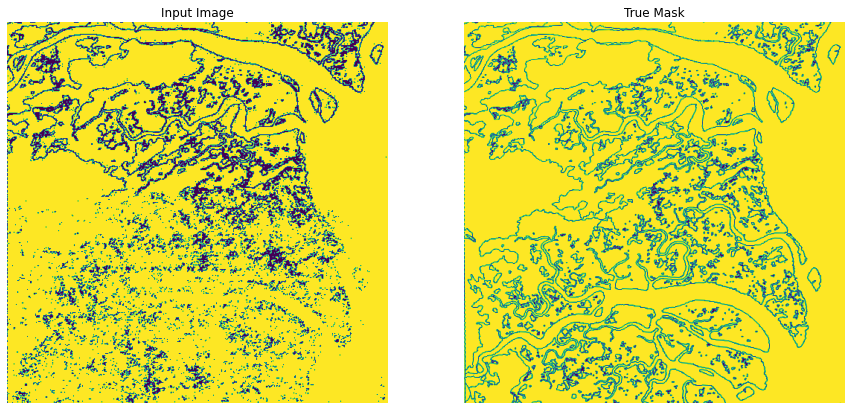

In [31]:
display([create_mask(pred),mask_tensor])

In [98]:
mask_tensor.shape

TensorShape([1, 512, 512, 1])

# Training network without patching